## 0. Setting up

In [1]:
import torch
import torchvision
print(torch.__version__, torchvision.__version__)

2.7.0+cu118 0.22.0+cpu


In [2]:
# 1) Move “up” until you hit the folder that contains pytorch/
import os
os.chdir(os.path.abspath(os.path.join(os.getcwd(), os.pardir, os.pardir)))
print("Working directory is now:", os.getcwd())

Working directory is now: c:\Users\Philippa\Documents\GitHub


In [6]:
import matplotlib.pyplot as plt
from torch import nn
from torchvision import transforms
from torchinfo import summary
import sys
from pytorch.TransferLearning.python_scripts import data_setup, engine

In [7]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

## 1. Getting data

In [8]:
import os
import zipfile

from pathlib import Path

import requests

# setup path to data folder
data_path = Path("data/")
image_path = data_path / "pizza_steak_sushi"
if image_path.is_dir():
    print(f"{image_path} already exists.")
else:
    print(f"Did not find {image_path} directory, creating one...")
    image_path.mkdir(parents=True, exist_ok=True)
    
    with open(data_path / "pizza_steak_sushi.zip", "wb") as f:
        request = requests.get("https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip")
        print("Downloading data...")
        f.write(request.content)
        
    # unzip the data
    with zipfile.ZipFile(data_path / "pizza_steak_sushi.zip", "r") as zip_ref:
        print("Unzipping data...")
        zip_ref.extractall(image_path)
    
    # remove .zip file
    os.remove(data_path / "pizza_steak_sushi.zip")

Did not find data\pizza_steak_sushi directory, creating one...
Unzipping data...


In [9]:
# set up training and testing directories
train_dir = image_path / "train"
test_dir = image_path / "test"

## 2. Create Datasets and DataLoaders

### 2.1 Manually creating a transform

In [10]:
# create transforms pipeline manually
manual_transforms = transforms.Compose([
    transforms.Resize((224,224)), # reshape all images to 224x224, though some models may require different sizes
    transforms.ToTensor(), # turn image values to between 0 and 1
    transforms.Normalize(mean=[0.485, 0.456, 0.406], # a mean of [0.485, 0.456, 0.406] (across each colour channel)
                         std=[0.229, 0.224, 0.225]) # A standard deviation of [0.229, 0.224, 0.225] (across each colour channel)
])

In [11]:
# create training and testing dataloaders and get a list of class names, using data_setup.py
train_dataloader, test_dataloader, class_names = data_setup.create_dataloaders(train_dir=train_dir,
                                                                               test_dir=test_dir,
                                                                               transform=manual_transforms,
                                                                               batch_size=32)

train_dataloader, test_dataloader, class_names

(<torch.utils.data.dataloader.DataLoader at 0x1df719d8980>,
 ['pizza', 'steak', 'sushi'])

### 2.2 Automatically creating a transform

In [12]:
# getting a set of pretrained model weights
weights = torchvision.models.EfficientNet_B0_Weights.DEFAULT # default is the best available weights from pretraining on ImageNet
weights

EfficientNet_B0_Weights.IMAGENET1K_V1

In [13]:
# get the transforms used to create the pretrained weights
auto_transforms = weights.transforms()
auto_transforms

ImageClassification(
    crop_size=[224]
    resize_size=[256]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BICUBIC
)

In [14]:
train_dataloader, test_dataloader, class_names = data_setup.create_dataloaders(train_dir=train_dir,
                                                                               test_dir=test_dir,
                                                                               transform=auto_transforms,
                                                                               batch_size=32)
train_dataloader, test_dataloader, class_names

(<torch.utils.data.dataloader.DataLoader at 0x1df719c9d10>,
 ['pizza', 'steak', 'sushi'])

## 3. Getting a pretrained model

The pretrained model that will be used is `torchvision.models.efficientnet_b0()`.

This model is taken from the paper: [EfficinetNet: Rethinking Model Scaling for Convolutional](https://arxiv.org/abs/1905.11946).

In [15]:
# set up model with pretrained weights and send it to the target device 
weights = torchvision.models.EfficientNet_B0_Weights.DEFAULT
model = torchvision.models.efficientnet_b0(weights=weights).to(device)

Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-7f5810bc.pth" to C:\Users\Philippa/.cache\torch\hub\checkpoints\efficientnet_b0_rwightman-7f5810bc.pth


100%|██████████| 20.5M/20.5M [00:00<00:00, 70.3MB/s]


### 3.1 Getting a summary of the model with `torchinfo.summary()`

In [16]:
summary(model=model,
        input_size=(32, 3, 224, 224),
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
        )

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [32, 3, 224, 224]    [32, 1000]           --                   True
├─Sequential (features)                                      [32, 3, 224, 224]    [32, 1280, 7, 7]     --                   True
│    └─Conv2dNormActivation (0)                              [32, 3, 224, 224]    [32, 32, 112, 112]   --                   True
│    │    └─Conv2d (0)                                       [32, 3, 224, 224]    [32, 32, 112, 112]   864                  True
│    │    └─BatchNorm2d (1)                                  [32, 32, 112, 112]   [32, 32, 112, 112]   64                   True
│    │    └─SiLU (2)                                         [32, 32, 112, 112]   [32, 32, 112, 112]   --                   --
│    └─Sequential (1)                                        [32, 32, 112, 112]   [32, 16, 112

### 3.2 Freezing the base model and changing the output layer to suit our needs

In [17]:
# freeze all base layers in the "features" section of the model
for param in model.features.parameters():
    param.requires_grad = False

In [19]:
# set manual seeds
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# get the length of class_names (one output unit for each class)
output_shape = len(class_names)

# recreate the classifier layer and send it to the target device
model.classifier = torch.nn.Sequential(
    torch.nn.Dropout(p=0.2, inplace=True),
    torch.nn.Linear(in_features=1280,
                    out_features=output_shape, # change the output features to the same length of our class names (pizza, steak, sushi)
                    bias=True)).to(device)

In [20]:
summary(model,
        input_size=(32, 3, 224, 224),
        verbose=0,
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [32, 3, 224, 224]    [32, 3]              --                   Partial
├─Sequential (features)                                      [32, 3, 224, 224]    [32, 1280, 7, 7]     --                   False
│    └─Conv2dNormActivation (0)                              [32, 3, 224, 224]    [32, 32, 112, 112]   --                   False
│    │    └─Conv2d (0)                                       [32, 3, 224, 224]    [32, 32, 112, 112]   (864)                False
│    │    └─BatchNorm2d (1)                                  [32, 32, 112, 112]   [32, 32, 112, 112]   (64)                 False
│    │    └─SiLU (2)                                         [32, 32, 112, 112]   [32, 32, 112, 112]   --                   --
│    └─Sequential (1)                                        [32, 32, 112, 112]   [32, 

## 4. Train model

In [21]:
# define loss and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [22]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)

from timeit import default_timer as timer 
start_time = timer()

# set up training and save the results
results = engine.train(model=model,
                       train_dataloader=train_dataloader,
                       test_dataloader=test_dataloader,
                       optimizer=optimizer,
                       loss_fn=loss_fn,
                       epochs=5,
                       device=device)

end_time = timer()
print(f"[INFO] Total training time: {end_time-start_time:.3f} seconds.")

 20%|██        | 1/5 [00:16<01:07, 16.98s/it]

Epoch: 1 | train_loss: 1.0924 | train_acc: 0.3984 | test_loss: 0.9133 | test_acc: 0.5398


 40%|████      | 2/5 [00:30<00:45, 15.01s/it]

Epoch: 2 | train_loss: 0.8717 | train_acc: 0.7773 | test_loss: 0.7912 | test_acc: 0.8153


 60%|██████    | 3/5 [00:44<00:28, 14.40s/it]

Epoch: 3 | train_loss: 0.7648 | train_acc: 0.7930 | test_loss: 0.7463 | test_acc: 0.8561


 80%|████████  | 4/5 [00:57<00:14, 14.05s/it]

Epoch: 4 | train_loss: 0.7109 | train_acc: 0.7539 | test_loss: 0.6373 | test_acc: 0.8655


100%|██████████| 5/5 [01:12<00:00, 14.41s/it]

Epoch: 5 | train_loss: 0.6255 | train_acc: 0.7852 | test_loss: 0.6261 | test_acc: 0.8561
[INFO] Total training time: 72.068 seconds.


## 5. Evaluate model by plotting loss curves

[INFO] Couldn't find helper_functions.py, downloading...


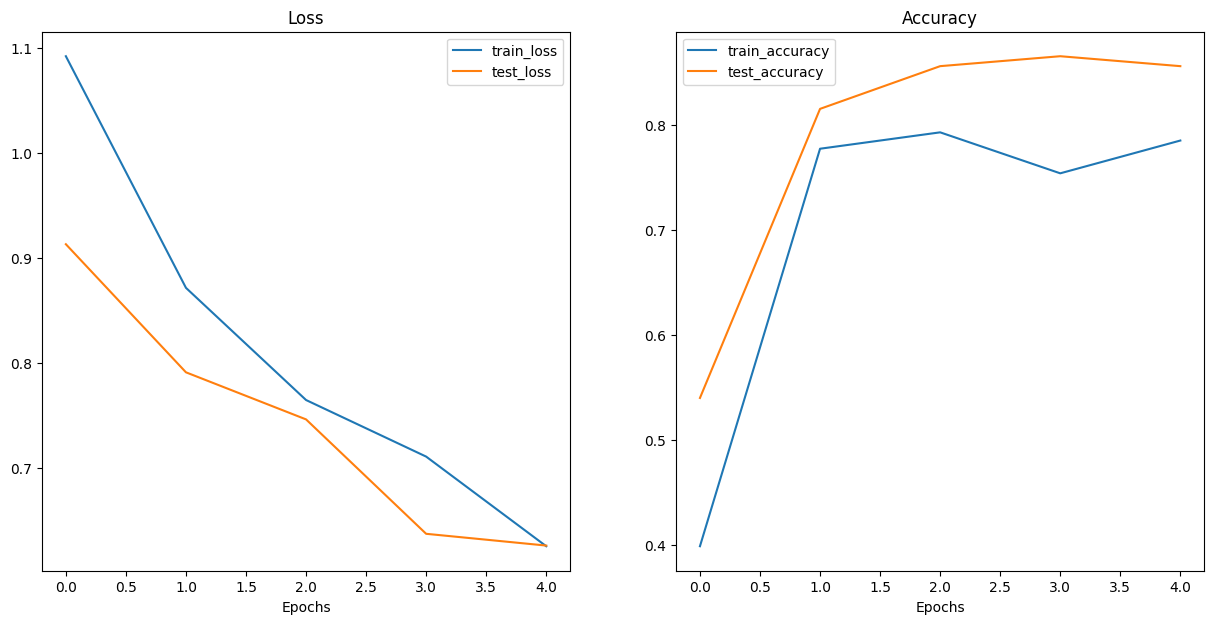

In [23]:
try:
    from helper_functions import plot_loss_curves
except:
    print("[INFO] Couldn't find helper_functions.py, downloading...")
    with open("helper_functions.py", "wb") as f:
        import requests
        request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py")
        f.write(request.content)
    from helper_functions import plot_loss_curves
    
plot_loss_curves(results)

## 6. Make predictions on images from the test set

In [34]:
from typing import List, Tuple
from PIL import Image

# take in a trained model, class names, image path, image size, a transform and target device
def pred_and_plot_image(model: torch.nn.Module,
                        image_path: str,
                        class_names: List[str],
                        image_size: Tuple[int, int] = (224, 224),
                        transform: torchvision.transforms = None,
                        device: torch.device=device):
    
    # open image
    img = Image.open(image_path)
    
    # create transformation for image if one doesn't exist
    if transform is not None:
        image_transform = transform
    else:
        image_transform = transforms.Compose([
            transforms.Resize(image_size),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])
        ])
        
    ## predict on image ##
    
    # make sure the model is on the target device
    model.to(device)
    
    #turn on model evaluation mode and inference mode
    model.eval()
    with torch.inference_mode():
        transformed_image = image_transform(img).unsqueeze(dim=0) # transform and add an extra dimension and send it to target device
        target_image_pred = model(transformed_image.to(device)) # make a prediction on image with an extra dimension and send it to target device
        
    target_image_pred_probs = torch.softmax(target_image_pred, dim=1) # convert logits -> prediction probabilities (softmax() is used for multi-class classification)
    
    target_image_pred_label = torch.argmax(target_image_pred_probs, dim=1) # convert prediction probabilities -> prediction labels
    
    # plot the image with predicted label and probability
    plt.figure()
    plt.imshow(img)
    plt.title(f"Pred: {class_names[target_image_pred_label]} | Prob: {target_image_pred_probs.max():.3f}")
    plt.axis(False);    

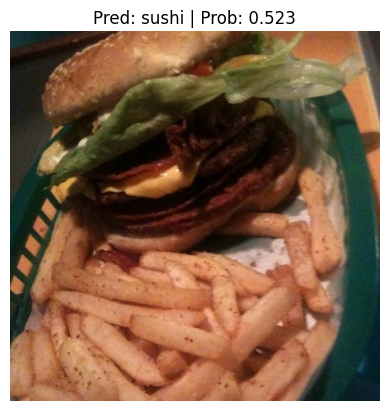

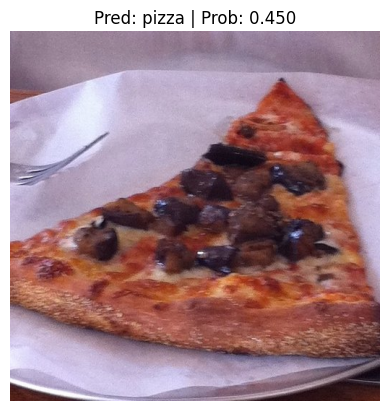

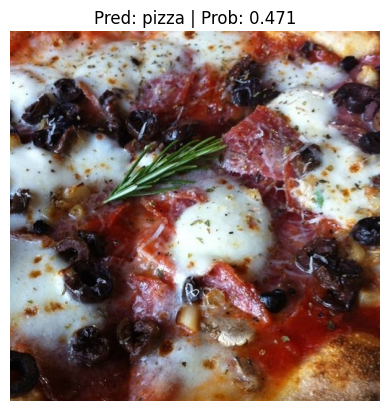

In [35]:
# get a random list of image paths from test set
import random
num_images_to_plot = 3
test_image_path_list = list(Path(test_dir).glob("*/*.jpg"))
test_image_path_sample = random.sample(population=test_image_path_list,
                                       k=num_images_to_plot)

# make predictions on and plot the images
for image_path in test_image_path_sample:
    pred_and_plot_image(model=model,
                        image_path=image_path,
                        class_names=class_names,
                        image_size=(224,224))